# Inverted Pendulum

In [1]:
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functions
import numpy as np
import random
from torch.distributions.normal import Normal
%matplotlib inline

In [2]:
# make a neural network for policy
class ActorNet(nn.Module):
    
    def __init__(self):
        super(ActorNet,self).__init__()
        self.fc1 = nn.Linear(3,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,2)    # output is std dev and mean
        
    def forward(self,x):
        x = functions.relu(self.fc1(x))
        x = functions.relu(self.fc2(x))
        x = self.fc3(x)
        soft = torch.nn.Softplus()
        x[:,1] = soft(x[:,1].clone())

        return x



# make a neural network for State Value function
class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet,self).__init__()
        self.fc1 = nn.Linear(3,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,1)    # output is state value

    def forward(self,x):
        x = functions.relu(self.fc1(x))
        x = functions.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [3]:
from collections import deque
 
class ReplayBuffer:
    
    def __init__(self,capacity):
        self.memory = deque(maxlen=capacity)
        
    def push(self,tup_le):
        self.memory.append(tup_le)
        
    def sample(self,sample_size):
        try:
            ob, action, reward, newob, done = zip(*random.sample(self.memory,sample_size))
        except:
            ob, action, reward, newob, done = zip(*random.sample(self.memory,len(self.memory)))
        
        return ob,action,reward,newob,done

In [4]:
class Agent:
    
    def __init__(self,env,Actor,Actor_optimizer,Critic,fixed_net_Critic,Critic_optimizer,buffercap,gamma = 0.99):
        #Critic
        self.Critic = Critic
        self.fixed_net_Critic = fixed_net_Critic
        self.Critic_optimizer = Critic_optimizer

        #Actor
        self.Actor = Actor
        self.Actor_optimizer = Actor_optimizer

        #Replay Memory and ENV
        self.gamma = gamma
        self.buffer = ReplayBuffer(buffercap)
        self.env = env
        
    
    def gen_episode(self,render = False,not_training = False):#generate one episode

        ob = self.env.reset()
        done = False
        reward_count = 0

        
        while(not done):

            ## get action
            with torch.no_grad():
                out = self.Actor(torch.from_numpy(ob.reshape(1,-1)).float().to(device))
                try:
                  dist = Normal(out[0,0],out[0,1])
                except:
                  print(out[0,0],out[0,1])
                  dist = Normal(out[0,0],out[0,1])
                action = dist.sample().cpu().numpy().reshape(1)   # because environment requires output in shape of 1

            
            newob, rew, done, _ = self.env.step(action)
            self.buffer.push((ob,action,rew,newob,done))
            if(not not_training):
                self.train_actor((ob,action,rew,newob,done))
            ob = newob
            reward_count += rew
            if(not not_training):
                self.train_critic()
        
        return reward_count/200
    

    def train_critic(self):   #perform one step of gradient descent
        batch_size = 64
        X,actions,rewards,Y,terminated = self.buffer.sample(batch_size)
        #print('Type of X is: ',type(X))

        X = np.array(X)
        #print('Shape of X is: ',X.shape)
        Y = np.array(Y)


        with torch.no_grad():
            Y = self.fixed_net_Critic(torch.from_numpy(Y).float().to(device)).cpu().numpy()
        #print(Y.shape)
        rewards = np.array(rewards)
        rewards = rewards.reshape(rewards.shape[0],1)
        terminated = np.array(terminated)
        terminated = terminated.reshape(terminated.shape[0],1)
        #print(1-terminated)
        Y = rewards + self.gamma*Y*(1-terminated)

        
        loss = nn.MSELoss()
        X = torch.from_numpy(X).float().to(device)
        Y = torch.from_numpy(Y).float().to(device)
        self.Critic_optimizer.zero_grad()
        output = self.Critic(X)
        cost = loss(output,Y)
        cost.backward(retain_graph=True)  #remove retain graph to get the error about the intermediate values being freed # add the retain graph line if you train the actor here
        self.Critic_optimizer.step()

        #start training actor
        #with torch.no_grad():
        #  adv = torch.from_numpy(rewards).float().to(device) + self.gamma*Y - output
        #self.Actor_optimizer.zero_grad()
        #actors_output = self.Actor(X)
        #loss = -1*torch.mean(torch.log(actors_output)*adv)
        #loss.backward()
        #self.Actor_optimizer.step()
        

    def train_actor(self,tup_le):
        states,actions,rewards,state_dashes,terminated = tup_le
        states = np.array(states)
        states = states.reshape(1,-1)
        state_dashes = np.array(state_dashes)
        state_dashes = state_dashes.reshape(1,-1)
        
        rewards = np.array(rewards)

        actions = np.array(actions)
        #print(type(actions),actions.shape)
        #print('Rewards shape is: ',rewards.shape)
        #print('Terminated shape is: ',terminated.shape)

        #define advantage function
        with torch.no_grad():
            V_s = self.Critic(torch.from_numpy(states).float().to(device))
            V_s_dash = self.Critic(torch.from_numpy(state_dashes).float().to(device))
        adv = torch.from_numpy(rewards).float().to(device) + self.gamma*V_s_dash - V_s
        
        self.Actor_optimizer.zero_grad()
        output = self.Actor(torch.from_numpy(states).float().to(device))
        #print('Output size is: ',output.size())
        dist = Normal(output[0,0],output[0,1])
        
        #print('Output is: ',output)
        loss = -1*dist.log_prob(torch.from_numpy(actions).to(device))*adv
        #print('Loss is: ',loss)
        loss.backward()
        self.Actor_optimizer.step()



In [5]:
if(torch.cuda.is_available()):
    print('CUDA Available')
device = torch.device('cuda')

CUDA Available


In [6]:
Actor = ActorNet().to(device)
Actor_optimizer = optim.Adam(Actor.parameters(),lr = 0.001)

Critic = CriticNet().to(device)
fixed_net_Critic = CriticNet().to(device)
Critic_optimizer = optim.Adam(Critic.parameters(),lr = 0.001)

In [7]:
name = 'Pendulum-v0'
env = gym.make(name)
agent = Agent(env,Actor,Actor_optimizer,Critic,fixed_net_Critic,Critic_optimizer,10000)

In [8]:
rewards = []
for i in range(1200):
    print(i,end=':(')
    if(i%25 == 0):
      agent.fixed_net_Critic.load_state_dict(agent.Critic.state_dict())
      print('changing fixed critic')
    reward = agent.gen_episode()
    print('{:.2}'.format(reward),end=')  ')
    rewards.append(reward)

0:(changing fixed critic
-7.1)  1:(-5.0)  2:(-5.0)  3:(-6.3)  4:(-7.0)  5:(-5.4)  6:(-4.5)  7:(-6.2)  8:(-9.3)  9:(-7.5)  10:(-7.9)  11:(-7.6)  12:(-8.9)  13:(-8.5)  14:(-6.9)  15:(-9.0)  16:(-8.2)  17:(-8.7)  18:(-9.0)  19:(-7.7)  20:(-7.1)  21:(-8.1)  22:(-7.1)  23:(-6.2)  24:(-7.9)  25:(changing fixed critic
-6.3)  26:(-5.0)  27:(-4.9)  28:(-4.8)  29:(-5.0)  30:(-4.5)  31:(-6.8)  32:(-7.9)  33:(-6.1)  34:(-8.9)  35:(-4.7)  36:(-6.9)  37:(-8.4)  38:(-7.3)  39:(-6.4)  40:(-5.8)  41:(-6.0)  42:(-4.3)  43:(-6.7)  44:(-8.6)  45:(-7.2)  46:(-8.1)  47:(-5.8)  48:(-7.2)  49:(-5.6)  50:(changing fixed critic
-7.8)  51:(-8.5)  52:(-7.3)  53:(-7.1)  54:(-7.1)  55:(-7.3)  56:(-8.9)  57:(-8.6)  58:(-8.9)  59:(-8.1)  60:(-7.9)  61:(-7.1)  62:(-7.3)  63:(-8.4)  64:(-6.8)  65:(-6.4)  66:(-7.9)  67:(-4.3)  68:(-6.9)  69:(-6.8)  70:(-8.4)  71:(-8.2)  72:(-7.9)  73:(-7.8)  74:(-8.6)  75:(changing fixed critic
-7.4)  76:(-6.7)  77:(-8.7)  78:(-7.8)  79:(-8.6)  80:(-8.3)  81:(-7.3)  82:(-7.7)  83:(-8.5)

-6.5)  626:(-4.7)  627:(-6.0)  628:(-7.4)  629:(-5.4)  630:(-5.9)  631:(-6.3)  632:(-4.3)  633:(-6.1)  634:(-5.2)  635:(-6.6)  636:(-6.5)  637:(-6.3)  638:(-5.9)  639:(-5.4)  640:(-6.4)  641:(-6.2)  642:(-7.3)  643:(-4.7)  644:(-7.5)  645:(-6.6)  646:(-7.5)  647:(-7.5)  648:(-4.0)  649:(-3.4)  650:(changing fixed critic
-0.68)  651:(-7.5)  652:(-7.5)  653:(-5.7)  654:(-5.2)  655:(-0.68)  656:(-5.7)  657:(-7.2)  658:(-5.3)  659:(-7.3)  660:(-6.9)  661:(-0.66)  662:(-7.6)  663:(-0.65)  664:(-0.67)  665:(-7.3)  666:(-0.65)  667:(-0.61)  668:(-0.66)  669:(-7.5)  670:(-0.66)  671:(-0.0024)  672:(-4.7)  673:(-0.0096)  674:(-5.3)  675:(changing fixed critic
-5.7)  676:(-0.018)  677:(-0.0057)  678:(-7.5)  679:(-0.67)  680:(-6.1)  681:(-0.66)  682:(-5.5)  683:(-6.4)  684:(-5.5)  685:(-7.4)  686:(-0.014)  687:(-7.5)  688:(-0.0036)  689:(-6.3)  690:(-6.7)  691:(-7.2)  692:(-7.5)  693:(-7.5)  694:(-6.5)  695:(-5.5)  696:(-5.6)  697:(-5.5)  698:(-7.5)  699:(-0.0052)  700:(changing fixed critic
-5.6

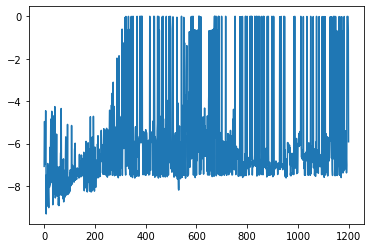

In [9]:
plt.plot(rewards)

In [19]:
rewards = []
for i in range(1000,1500):
    print(i,end=':(')
    if(i%25 == 0):
      agent.fixed_net_Critic.load_state_dict(agent.Critic.state_dict())
      print('changing fixed critic')
    reward = agent.gen_episode()
    print('{:.2}'.format(reward),end=')  ')
    rewards.append(reward)

1000:(changing fixed critic
-3.9)  1001:(-2.0)  1002:(-1.4)  1003:(-0.11)  1004:(-1.4)  1005:(-0.77)  1006:(-7.5)  1007:(-3.1)  1008:(-3.2)  1009:(-2.1)  1010:(-1.4)  1011:(-0.74)  1012:(-0.1)  1013:(-1.5)  1014:(-1.3)  1015:(-0.058)  1016:(-5.0)  1017:(-3.0)  1018:(-1.4)  1019:(-0.69)  1020:(-0.7)  1021:(-0.67)  1022:(-0.68)  1023:(-0.68)  1024:(-0.051)  1025:(changing fixed critic
-6.0)  1026:(-0.67)  1027:(-0.74)  1028:(-1.9)  1029:(-4.1)  1030:(-1.4)  1031:(-4.2)  1032:(-1.4)  1033:(-1.4)  1034:(-1.6)  1035:(-2.9)  1036:(-1.6)  1037:(-0.73)  1038:(-1.4)  1039:(-0.74)  1040:(-1.4)  1041:(-1.9)  1042:(-1.4)  1043:(-1.4)  1044:(-2.2)  1045:(-3.4)  1046:(-1.4)  1047:(-2.0)  1048:(-5.3)  1049:(-0.72)  1050:(changing fixed critic
-0.72)  1051:(-0.7)  1052:(-0.72)  1053:(-0.68)  1054:(-1.3)  1055:(-1.3)  1056:(-2.1)  1057:(-0.036)  1058:(-5.1)  1059:(-2.1)  1060:(-1.9)  1061:(-0.7)  1062:(-2.6)  1063:(-3.6)  1064:(-0.68)  1065:(-1.3)  1066:(-2.0)  1067:(-4.9)  1068:(-0.69)  1069:(-0.68)  

In [10]:
rewards = np.array(rewards)
np.save('InvPenduFin.npy',rewards)

In [11]:
torch.save(Critic.state_dict(),'InvPenduCriticFin.pth')
torch.save(Actor.state_dict(),'InvPenduActorFin.pth')

In [23]:
checkward = agent.gen_episode(not_training = True)
print(checkward)

-6.509543228329405


# Previous Graphs

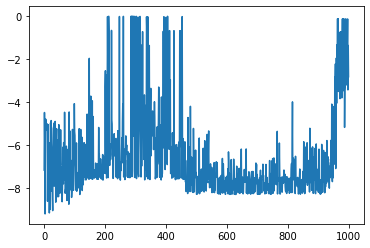

In [9]:
plt.plot(rewards)

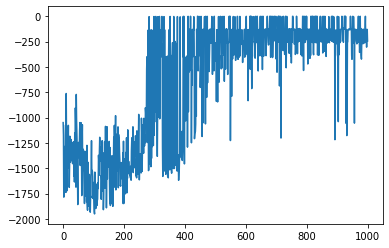

In [ ]:
plt.plot(rewards[:1000]*200)

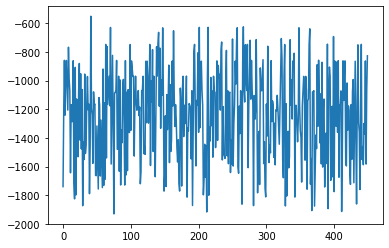

In [ ]:
plt.plot(rewards)

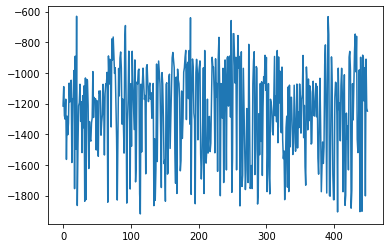

In [ ]:
plt.plot(rewards)